In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from IPython.display import clear_output

import os
import shutil
import sys
import pickle

import numpy as np 
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

import random

import lmdb
from PIL import Image
import tempfile

import requests, zipfile, io

%matplotlib inline

In [0]:
try:
    shutil.rmtree('data')
#     os.mkdir('data')

except FileNotFoundError:
    pass
#     os.mkdir('data')

os.mkdir('data')

In [0]:
# shutil.rmtree('lsun_data')

In [0]:
def _maybe_download(index='http://dl.yf.io/lsun/scenes/', file_name='church_outdoor_val_lmdb.zip'):
    ''' downloads the LSUN data into the lsun_data folder and extracts the zip file
        
        Args:
        
            index: at the time of creation of this file, the 
            all the LSUN files were available at this link 
            'http://dl.yf.io/lsun/scenes/'
            
            file_name: name of the file with extension
            eg: 'church_outdoor_val_lmdb.zip'
        
        '''
    
    zip_file_url = index + file_name
    
    if 'lsun_data' not in os.listdir():
        os.mkdir('lsun_data')
    
    if file_name.split('.')[0] not in os.listdir('lsun_data'):
        r = requests.get(zip_file_url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall('lsun_data/')

In [0]:
def _export_mdb_images(db_path, out_dir=None, flat=True, limit=-1, size=256):
    
    ''' 
        exports the contents of the mdb (microsoft access database) file as 
        individual image files (.jpg)
        
        Args:
            
            db_path: the directory path where the .mdb database is present
            out_dir: the directory path to which the .jpg files will be stored
            size: the size of the exported jpg file. by default, it is 64x64 pixels
            because most modern GPUs can handle upto that size 
    
    '''
    try:
        os.mkdir(out_dir)
    except:
        pass
    
    
    for file in os.listdir(out_dir):
        if file.endswith('.jpg'):
            print('The files are already exported')
            return
    
    out_dir = out_dir
    env = lmdb.open(
        db_path, map_size=1099511627776,
        max_readers=1000, readonly=True
    )
    count = 0
    with env.begin(write=False) as txn:
        cursor = txn.cursor()
        for key, val in cursor:
            key = str(key, 'utf-8')
            # decide image out directory
            if not flat:
                image_out_dir = os.path.join(out_dir, '/'.join(key[:6]))
            else:
                image_out_dir = out_dir

            # create the directory if an image out directory doesn't exist
            if not os.path.exists(image_out_dir):
                os.makedirs(image_out_dir)

            with tempfile.NamedTemporaryFile('wb') as temp:
                temp.write(val)
                temp.flush()
                temp.seek(0)
                image_out_path = os.path.join(image_out_dir, key + '.jpg')
                Image.open(temp.name).resize((size, size)).save(image_out_path)
            count += 1
            if count == limit:
                break
            if count % 1000 == 0:
                print('Finished', count, 'images')
                

In [0]:
def download_and_export(index, file_name, size=64):
    
    ''' 
        wrapper function to download and export the image files
        
        Args:
        
            index: at the time of creation of this file, the 
            all the LSUN files were available at this link 
            'http://dl.yf.io/lsun/scenes/'
            
            file_name: name of the file with extension
            eg: 'church_outdoor_val_lmdb.zip'
            
            size: the size of the exported jpg file. by default, it is 64x64 pixels
            because most modern GPUs can handle upto that size 
            
    '''
    
    _maybe_download(index, file_name)
    file_name_without_extension = file_name.split('.')[0]
    _export_mdb_images(f'lsun_data/{file_name_without_extension}', out_dir=f'lsun_data/{file_name_without_extension}/exported', flat=True, limit=-1, size=size)

In [0]:
def save_as_npy(file_name_without_extension):
    img_folder = f'lsun_data/{file_name_without_extension}/exported/'
    to_file_path = f'lsun_data/{file_name_without_extension}/{file_name_without_extension}'
    
    if file_name_without_extension + '.npy' not in os.listdir(f'lsun_data/{file_name_without_extension}'):
        all_images_array = []
        for image in os.listdir(img_folder):
            img_array = list(imread(img_folder + image))
            all_images_array.append(img_array)

        np.save(to_file_path, np.array(all_images_array))

    else:
        print(f"{file_name_without_extension}.npy file is already present in the folder \nTherefore Not creating the file again!")

In [0]:
# index = 'http://dl.yf.io/lsun/scenes/'
# file_name = 'kitchen_val_lmdb.zip'
# file_name_without_extension = file_name.split('.')[0]

# download_and_export(index, file_name)
# # save_as_npy(file_name_without_extension)

In [0]:
class Discriminator:
    def __init__(self, width, height, channels, latent_size=100, model_type='simple'):
        
        self.CAPACITY = width*height*channels
        self.SHAPE = (width, height, channels)
        
        # initialize the model based on the method we will define later
        if model_type.lower() == 'simple':
            self.Discriminator = self.model()
            self.OPTIMIZER = tf.keras.optimizers.Adam(lr=0.0002, decay=8e-9)
            
            
        elif model_type.lower() == 'dcgan':
            self.Discriminator = self.dc_model()
            self.OPTIMIZER = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.2)
            
        else:
            raise ValueError('provide a valid model_type')
        
        # compile a model with a binary_crossentropy loss and our specified optimizer
        self.Discriminator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'])
        

        # display the text summary of the model on the terminal
        self.Discriminator.summary()
        
        # self.save_model()

    def model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=self.SHAPE))
        
        model.add(tf.keras.layers.Dense(self.CAPACITY, input_shape=self.SHAPE))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

        model.add(tf.keras.layers.Dense(int(self.CAPACITY / 2)))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        return model

    def dc_model(self):
        model = tf.keras.models.Sequential()
        
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, input_shape=self.SHAPE, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Flatten())
        
        model.add(tf.keras.layers.Dense(1024))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.Dropout(0.5))
        
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        
        
        return model

    
    def summary(self):
        return self.Discriminator.summary()

    def save_model(self):
        with open('models/discriminator_model.pickle', 'wb') as dis_file:
            pickle.dump(self.Discriminator, dis_file)
            

In [0]:
class Generator:
    def __init__(self, width=28, height=28, channels=1, latent_size=100, model_type='simple'):
        self.W = width 
        self.H = height 
        self.C = channels 

        self.LATENT_SPACE_SIZE = latent_size 
        self.latent_space = np.random.normal(0, 1, self.LATENT_SPACE_SIZE)
        
        # initialize the model based on the method we will define later
        if model_type.lower() == 'simple':
            self.Generator = self.model()
            self.OPTIMIZER = tf.keras.optimizers.Adam(lr=0.0002, decay=8e-9)
            
            # compile a model with a binary_crossentropy loss and our specified optimizer
            self.Generator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
            
        elif model_type.lower() == 'dcgan':
            self.Generator = self.dc_model()
            self.OPTIMIZER = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.2)
            
            # compile a model with a binary_crossentropy loss and our specified optimizer
            self.Generator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'])   
            
        else:
            raise ValueError('provide a valid model_type')

        

        # display the text summary of the model on the terminal
        self.Generator.summary()
        
        # self.save_model()

    def model(self, block_starting_size=128, num_blocks=4):
        model = tf.keras.models.Sequential()
        
        block_size = block_starting_size
        model.add(tf.keras.layers.Dense(block_size, input_shape=(self.LATENT_SPACE_SIZE,)))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
        model.add(tf.keras.layers.BatchNormalization(momentum=0.8))

        for _ in range(num_blocks-1):
            block_size = block_size * 2
            model.add(tf.keras.layers.Dense(block_size))
            model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
            model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
        
        model.add(tf.keras.layers.Dense(self.W * self.H * self.C, activation='tanh'))
        model.add(tf.keras.layers.Reshape((self.W, self.H, self.C)))

        return model 
    
    def dc_model(self):
        model = tf.keras.models.Sequential()
        
        model.add(tf.keras.layers.Dense(256*8*8, input_shape=(self.LATENT_SPACE_SIZE,)))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Reshape((8, 8, 256)))
        model.add(tf.keras.layers.UpSampling2D())
        
        model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.UpSampling2D())
        
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.UpSampling2D())
        
        model.add(tf.keras.layers.Conv2D(filters=self.C, kernel_size=5, padding='same', activation='tanh'))
        
        
        return model 
    
    
    def summary(self):
        return self.Generator.summary()

    def save_model(self):
        with open('models/generator_model.pickle', 'wb') as gen_file:
            pickle.dump(self.Generator, gen_file)
        

In [0]:
class GAN:
    def __init__(self, discriminator, generator):
        # self.OPTIMIZER = tf.keras.optimizers.Adam(lr=0.0002, decay=8e-9)
        self.OPTIMIZER = tf.keras.optimizers.SGD(lr=2e-4, nesterov=True)
        
        self.Generator = generator
        self.Discriminator = discriminator
        self.Discriminator.trainable = False 
        
        self.gan_model = self.model()
        self.gan_model.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        self.gan_model.summary()

    def model(self):
        model = tf.keras.models.Sequential()
        model.add(self.Generator)
        model.add(self.Discriminator)
        return model 
    
    def summary(self):
        return self.gan_model.summary()
    
    def save_model(self):
        tf.keras.utils.plot_model(self.gan_model, to_file='data/GAN_Model.png')

In [0]:
class Trainer:
    def __init__(self, width=28, height=28, channels=1, latent_size=100, epochs=5000, batch=32, checkpoint=50, model_type='simple', file_name_without_extension='restaurant_val_lmdb'):
        self.W = width
        self.H = height
        self.C = channels
        self.EPOCHS = epochs
        self.BATCH = batch
        self.CHECKPOINT = checkpoint
        self.model_type = model_type.lower()
        self.LATENT_SPACE_SIZE = latent_size
        self.file_name_without_extension = file_name_without_extension

        self.generator = Generator(self.W, self.H, self.C, self.LATENT_SPACE_SIZE, model_type=self.model_type)
        self.discriminator = Discriminator(self.W, self.H, self.C, model_type=self.model_type)
        self.gan = GAN(self.discriminator.Discriminator, self.generator.Generator)

        self.load_LSUN(self.file_name_without_extension, self.H)
    
    def load_LSUN(self, file_name_without_extension, size):

        self.X_train = np.load(f'lsun_data/{file_name_without_extension}/{file_name_without_extension}.npy')

        # self.X_train = self.X_train[:int()]
        
        self.X_train = (np.float32(self.X_train) - 127.5) / 127.5
        self.X_train = np.expand_dims(self.X_train, axis=3)

        return
    
    def batch_index_generator(self, X_train_size, batch_size):
        batch_indexes = np.arange(0, X_train_size-batch_size, batch_size)
        np.random.shuffle(batch_indexes)
        
        for i in batch_indexes:
            yield i
            
    def flipCoin(self,chance=0.5):
        return np.random.binomial(1, chance)
    
    
    def train(self):
        
        with open('data/log.csv', 'a') as logfile:
            logfile.write(f'epoch,discriminator_loss,generator_loss\n')


        for e in range(self.EPOCHS):
            batch_index_iter = self.batch_index_generator(len(self.X_train), self.BATCH)
            
            current_batch_number = 0
            total_batches = int(len(self.X_train)/self.BATCH)
            try:
                while True:
                    print(f'current_batch_number : {current_batch_number} | epoch : {e}')
                    current_batch_number += 1
                    
                    if self.flipCoin():
                        # we grabbed only half of the batch size because the other half will come from the generator
                        count_real_images = int(self.BATCH)
                        starting_index = next(batch_index_iter)

                        real_images_raw = self.X_train[starting_index : (starting_index+count_real_images)]
                        x_batch = real_images_raw.reshape(count_real_images, self.W, self.H, self.C)
                        y_batch = np.ones([count_real_images, 1])
                    
                    else:
                        latent_space_samples = self.sample_latent_space(self.BATCH)
                        x_batch = self.generator.Generator.predict(latent_space_samples)
                        y_batch = np.zeros([self.BATCH, 1])

                    
                    # now train the discriminator with this batch
                    discriminator_loss = self.discriminator.Discriminator.train_on_batch(x_batch, y_batch)[0]


                    # In practice, flipping the label when training the generator improves convergence
                    if self.flipCoin(chance=0.9):
                        y_generated_labels = np.ones([self.BATCH, 1])
                    else:
                        y_generated_labels = np.zeros([self.BATCH, 1])
                        
                    x_latent_space_samples = self.sample_latent_space(self.BATCH)
                    generator_loss = self.gan.gan_model.train_on_batch(x_latent_space_samples, y_generated_labels)

            except StopIteration:
                pass


            if e%self.CHECKPOINT == 0:
                clear_output(wait=True)
                with open('data/log.csv', 'a') as logfile:
                    logfile.write(f'{e}, {discriminator_loss}, {generator_loss} \n')
                print(f'Epoch : {e} \nDiscriminator loss : {discriminator_loss} \nGenerator loss: {generator_loss}')

                self.plot_checkpoint(e)

        return
    
    def sample_latent_space(self, instances):
        return np.random.normal(0, 1, (instances, self.LATENT_SPACE_SIZE))

    def plot_checkpoint(self, e):
        filename = f'data/sample_{e}.png'
        noise = self.sample_latent_space(16)
        images = self.generator.Generator.predict(noise)

        # in this case we produced 16 images at each epoch checkpoint
        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4,4,i+1)
            
            image = images[i, :, :, :]
            image = np.reshape(image, [self.H, self.W, self.C])
            image = (255*(image - np.min(image))/np.ptp(image)).astype(int)
            plt.imshow(image)
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(filename)
        plt.close('all')
        
        self.save_image_to_drive(f'data/sample_{e}.png')
        return
    
    def save_image_to_drive(self, file_path):
        file_name = file_path.split('/')[-1]
        try:
            os.mkdir('drive/My Drive/dcgan_models')
        except:
            pass

        shutil.copyfile(file_path, f'drive/My Drive/dcgan_models/{file_name}')
    

In [0]:
HEIGHT = 64
WIDTH = 64
CHANNEL = 3
LATENT_SPACE_SIZE = 100
EPOCHS = 101
BATCH = 128
CHECKPOINT = 1
MODEL_TYPE = 'dcgan'
FILE_NAME_WITHOUT_EXTENSION = 'church_outdoor_train_lmdb'

index = 'http://dl.yf.io/lsun/scenes/'


In [0]:
download_and_export(index, FILE_NAME_WITHOUT_EXTENSION + '.zip')
save_as_npy(FILE_NAME_WITHOUT_EXTENSION)

Finished 1000 images
Finished 2000 images
Finished 3000 images
Finished 4000 images
Finished 5000 images
Finished 6000 images
Finished 7000 images
Finished 8000 images
Finished 9000 images
Finished 10000 images
Finished 11000 images
Finished 12000 images
Finished 13000 images
Finished 14000 images
Finished 15000 images
Finished 16000 images
Finished 17000 images
Finished 18000 images
Finished 19000 images
Finished 20000 images
Finished 21000 images
Finished 22000 images
Finished 23000 images
Finished 24000 images
Finished 25000 images
Finished 26000 images
Finished 27000 images
Finished 28000 images
Finished 29000 images
Finished 30000 images
Finished 31000 images
Finished 32000 images
Finished 33000 images
Finished 34000 images
Finished 35000 images
Finished 36000 images
Finished 37000 images
Finished 38000 images
Finished 39000 images
Finished 40000 images
Finished 41000 images
Finished 42000 images
Finished 43000 images
Finished 44000 images
Finished 45000 images
Finished 46000 imag

In [0]:
trainer = Trainer(WIDTH, HEIGHT, CHANNEL, LATENT_SPACE_SIZE, EPOCHS, BATCH, CHECKPOINT, MODEL_TYPE, FILE_NAME_WITHOUT_EXTENSION)
trainer.train()

Epoch : 68 
Discriminator loss : 0.06083071231842041 
Generator loss: 5.173994064331055
current_batch_number : 0 | epoch : 69
current_batch_number : 1 | epoch : 69
current_batch_number : 2 | epoch : 69
current_batch_number : 3 | epoch : 69
current_batch_number : 4 | epoch : 69
current_batch_number : 5 | epoch : 69
current_batch_number : 6 | epoch : 69
current_batch_number : 7 | epoch : 69
current_batch_number : 8 | epoch : 69
current_batch_number : 9 | epoch : 69
current_batch_number : 10 | epoch : 69
current_batch_number : 11 | epoch : 69
current_batch_number : 12 | epoch : 69
current_batch_number : 13 | epoch : 69
current_batch_number : 14 | epoch : 69
current_batch_number : 15 | epoch : 69
current_batch_number : 16 | epoch : 69
current_batch_number : 17 | epoch : 69
current_batch_number : 18 | epoch : 69
current_batch_number : 19 | epoch : 69
current_batch_number : 20 | epoch : 69
current_batch_number : 21 | epoch : 69
current_batch_number : 22 | epoch : 69
current_batch_number : 23

'drive/My Drive/dcgan_models/log.csv'

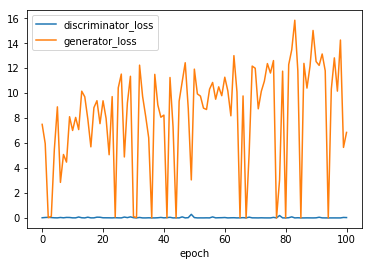

In [0]:
logdf = pd.read_csv('data/log.csv')
logdf.plot(kind='line', x='epoch', y=['discriminator_loss', 'generator_loss'], legend=True)

shutil.copyfile('data/log.csv', 'drive/My Drive/dcgan_models/log.csv')

In [0]:
trainer.generator.Generator.save('drive/My Drive/dcgan_models/generator_weights.h5')
trainer.discriminator.Discriminator.save('drive/My Drive/dcgan_models/discriminator_weights.h5')
trainer.gan.gan_model.save('drive/My Drive/dcgan_models/gan_weights.h5')


In [0]:
generator_json = trainer.generator.Generator.to_json()
discriminator_json = trainer.discriminator.Discriminator.to_json()
gan_json = trainer.gan.gan_model.to_json()

with open("drive/My Drive/dcgan_models/generator_architecture.json", "w") as json_file:
    json_file.write(generator_json)

with open("drive/My Drive/dcgan_models/discriminator_architecture.json", "w") as json_file:
    json_file.write(discriminator_json)

with open("drive/My Drive/dcgan_models/gan_architecture.json", "w") as json_file:
    json_file.write(gan_json)


In [0]:
# # load json and create model
# json_file = open('model_num.json', 'r')

# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

# # load weights into new model
# loaded_model.load_weights("model_num.h5")
# print("Loaded model from disk")

# loaded_model.save('model_num.hdf5')
# loaded_model=load_model('model_num.hdf5')


# loaded_model.predict_classes("your_test_data here")